In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from math import ceil, sqrt
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
sys.path.append('../')
from data.datasets import SSWEDataset
from neuralop.utils import count_model_params
from matplotlib import pyplot as plt
import cmcrameri.cm as cmc
from timeit import default_timer
from utils.losses import EnergyScore, KernelScore, VariogramScore, LpLoss, SphericalL2Loss
from models.fno import FNO, SFNO
from models.pfno import PFNO, PSFNO
from models.pfno import PNO_Wrapper
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

# Set torch seed
torch.manual_seed(0)

In [2]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_horizon = 5
n_train_steps = 2

In [3]:
data_dir = "../data/SSWE/processed/"
train_data = SSWEDataset(data_dir, test = False, pred_horizon = n_train_steps, return_all = True)
test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon)


x,y,t = train_data.get_coordinates()
L = train_data.get_domain_range()
weights = train_data.weights
nlon = train_data.nlon

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


n_train = len(train_loader)
n_test = len(test_loader)

# Visualize

In [4]:
for a,u in test_loader:
    break
Lons, Lats = np.meshgrid(y,x)

Text(0.5, 1.0, 'Output')

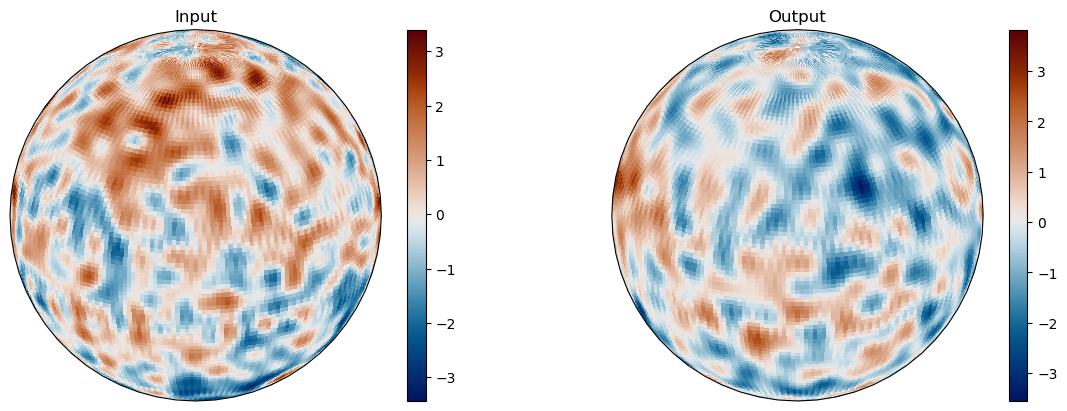

In [5]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(1,2, figsize = (12,4), subplot_kw={'projection': proj}, layout = "constrained")

# contour data over the map.
im = axs[0].pcolormesh(Lons, Lats, a[0,0], transform=ccrs.PlateCarree(), antialiased = False)
plt.colorbar(im)
axs[0].set_title("Input")

im = axs[1].pcolormesh(Lons, Lats, u[0,0], transform=ccrs.PlateCarree(), antialiased = False)
plt.colorbar(im)
axs[1].set_title("Output")

# Run Model

In [6]:
# Losses and parameters
l2loss = SphericalL2Loss(nlon = nlon, weights = weights.to(device))
energy_score = EnergyScore(type = "spherical", nlon = nlon, weights = weights.to(device))


# Training parameters
epochs = 2
learning_rate = 0.002
dropout_rate = 0.02
max_train = 1000

In [7]:
dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
dropout_model = dropout_model.to(device)


n_params = count_model_params(dropout_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 277923 parameters.


In [8]:
optimizer = torch.optim.Adam(dropout_model.parameters(),lr=learning_rate)

In [9]:
train_loss = torch.zeros(epochs)

for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,0].to(device)

        optimizer.zero_grad()
        out = dropout_model(a)
        
        l2 = l2loss(out, u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.6f}'.format(ep, t2-t1, train_l2))

optimizer = torch.optim.Adam(dropout_model.parameters(),lr=0.0001)
print("Fine tuning!")

train_loss = torch.zeros(epochs)
for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,1].to(device)
        optimizer.zero_grad()
        out = dropout_model(a)
        l_step = l2loss(out, u)
        for _ in range(1):
            out = dropout_model(out)
            l_step += l2loss(out, u)
        
        l2 = (l_step + l2loss(out, u))/2
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.6f}'.format(ep, t2-t1, train_l2))

Epoch-0, Time-127.3551, Train-L2-4.329575
Epoch-1, Time-6.0562, Train-L2-2.894150
Fine tuning!
Epoch-0, Time-9.8462, Train-L2-6.160655
Epoch-1, Time-9.8315, Train-L2-6.064493


# MCDropout

In [10]:
""" Prediction """
mse_dropout = 0
es_dropout = 0

with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        # Autoregressive steps
        dropout_model.eval()
        for _ in range(eval_horizon-1):
            a = dropout_model(a)
        
        dropout_model.train()
        out = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        mse_dropout += l2loss(out.mean(axis = -1), u).item() / n_test
        es_dropout += energy_score(out, u).item() / n_test


print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 3.8548632268621508
ES: 3.564268230956417


# Laplace approximation

In [11]:
la_model = LA_Wrapper(dropout_model, n_samples=n_samples, method = "last_layer", hessian_structure = "full", optimize = True)
la_model.fit(test_loader)

In [12]:
""" Prediction """
mse_la = 0
es_la = 0
la_model.model.eval()
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        # Autoregressive steps
        for _ in range(eval_horizon-1):
            a = la_model.model(a)        
        out = la_model.predictive_samples(a)
        mse_la += l2loss(out.mean(axis = -1), u).item() / n_test
        es_la += energy_score(out, u).item() / n_test


print('MSE:', mse_la)
print('ES:', es_la)

MSE: 3.851524345679194
ES: 3.2457330578025285


# PFNO

In [13]:
# hidden_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
# hidden_model = hidden_model.to(device)
pfno_model = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = None, n_samples = 3)
pfno_model.to(device)

# pfno_model = PNO_Wrapper(hidden_model, n_samples = 3)
# pfno_model.to(device)

n_params = count_model_params(pfno_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

optimizer = torch.optim.Adam(pfno_model.parameters(),lr=learning_rate)


Our model has 280230 parameters.


In [14]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,0].to(device)
        optimizer.zero_grad()
        out = pfno_model(a)
        
        l2 = energy_score(out,u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}'.format(ep, t2-t1, train_l2))
print("Fine tuning!")

for ep in range(epochs):
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,1].to(device)
        optimizer.zero_grad()
        out = pfno_model(a)
        l_step = energy_score(out,u)
        out = pfno_model(out.mean(axis = -1))
        
        l2 = (l_step + energy_score(out,u))/2
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}'.format(ep, t2-t1, train_l2))

Epoch-0, Time-8.0021, Train-L2-3.1577
Epoch-1, Time-7.8958, Train-L2-2.0958
Fine tuning!
Epoch-0, Time-13.6784, Train-L2-2.9918
Epoch-1, Time-13.8156, Train-L2-2.5219


In [15]:
pfno_model.eval()
""" Prediction """
mse_pfno = 0
es_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        # Autoregressive steps
        for _ in range(eval_horizon-1):
            a = pfno_model(a, n_samples = 3)
            a = a.mean(axis = -1)

        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1), u).item() / n_test
        es_pfno += energy_score(out, u).item() / n_test


print('MSE:', mse_pfno)
print('ES:', es_pfno)

MSE: 5.641400777145505
ES: 4.147702999803337


# Compare Metrics

In [16]:
print(f"Dropout \nMSE: {mse_dropout} \t ES: {es_dropout}")
print(f"LA \nMSE: {mse_la} \t ES: {es_la}")
print(f"PFNO \nMSE: {mse_pfno} \t ES: {es_pfno}")

Dropout 
MSE: 3.8548632268621508 	 ES: 3.564268230956417
LA 
MSE: 3.851524345679194 	 ES: 3.2457330578025285
PFNO 
MSE: 5.641400777145505 	 ES: 4.147702999803337


# Visualizations

In [17]:
n_samples = 100

In [18]:
sample = np.random.randint(0,len(test_data))
print(sample)

dropout_model.eval()
""" Prediction """
truth = []
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    # Dropout
    out = dropout_model(a)
    for _ in range(1,eval_horizon-1):
        out = dropout_model(out)
    dropout_model.train()
    dropout_pred = generate_mcd_samples(dropout_model, out, u.shape, n_samples=n_samples)

    # LA
    out = la_model.model(a)
    for _ in range(1,eval_horizon-1):
        out = la_model.model(out)
    la_pred = la_model.predictive_samples(out)

    # PFNO
    out = pfno_model(a)
    for _ in range(1,eval_horizon-1):
        out = pfno_model(out.mean(axis = -1))
    pfno_pred = pfno_model(out.mean(axis = -1), n_samples = n_samples)
        

    pred_dropout.append( dropout_pred )
    pred_pfno.append( pfno_pred )
    pred_la.append( la_pred )
    truth.append( u )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()
truth = torch.cat(truth, dim = 0).cpu().numpy()

27


In [19]:
idx = 0
preds = [pred_dropout, pred_la, pred_pfno]

Text(0, 0.5, 'PFNO')

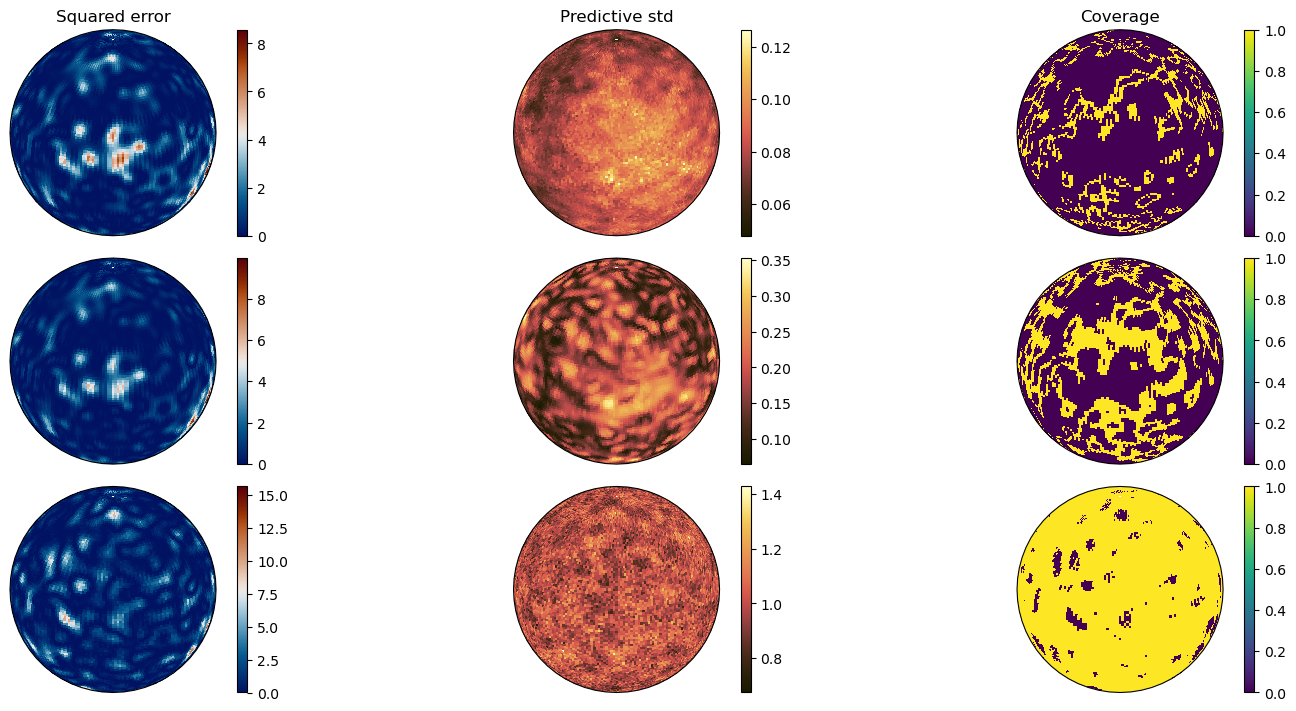

In [20]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,3, figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    # im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    # plt.colorbar(im)

    im = axs[i,0].pcolormesh(Lons, Lats, np.power(pred[idx,0].mean(axis = -1)-truth[idx,0],2), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,1].pcolormesh(Lons, Lats, pred[idx,0].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,0],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,0],1-alpha/2, axis = -1)
    coverage = (truth[idx,0]>q_lower) & (truth[idx,0]<q_upper)

    im = axs[i,2].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0,0].set_title("Squared error")
axs[0,1].set_title("Predictive std")
axs[0,2].set_title("Coverage")

axs[0,0].set_ylabel("MCDropout")
axs[1,0].set_ylabel("LA")
axs[2,0].set_ylabel("PFNO")

Text(0, 0.5, 'PFNO')

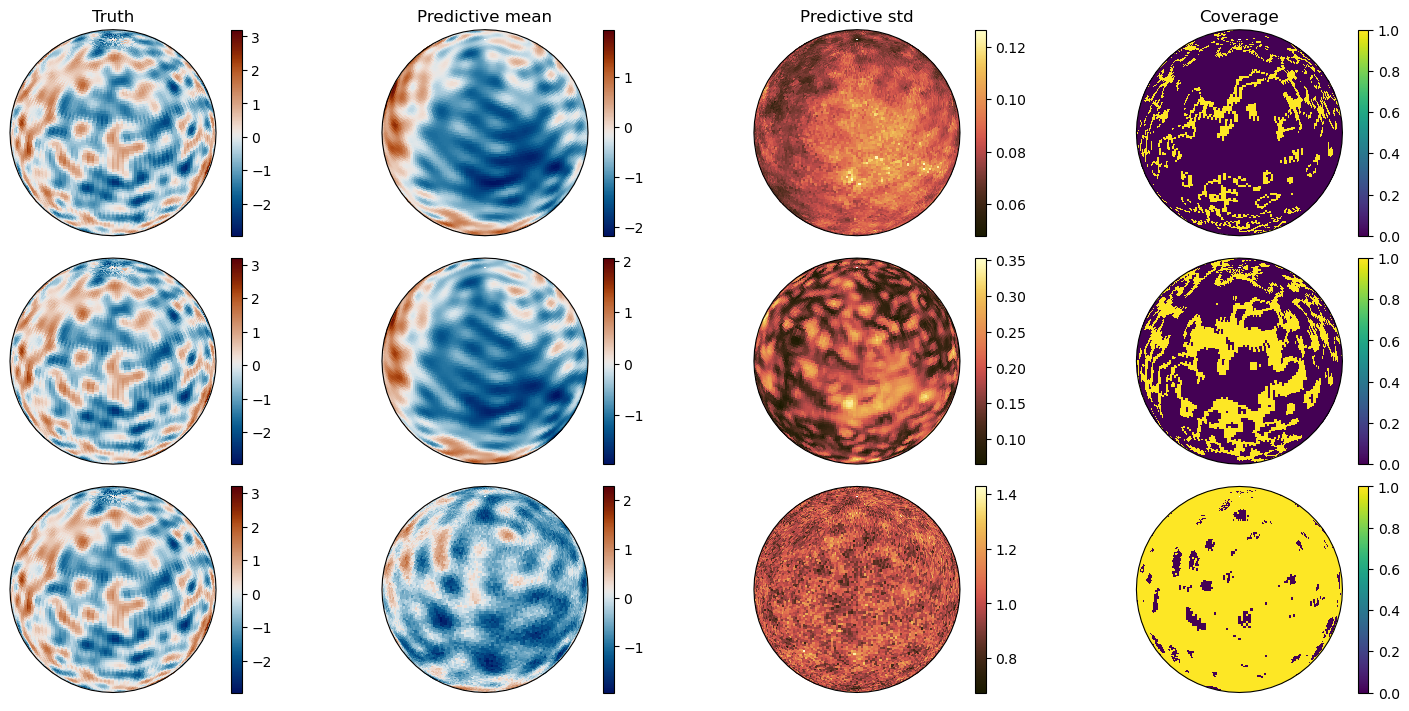

In [21]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,4, figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,1].pcolormesh(Lons, Lats, pred[idx,0].mean(axis = -1), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,2].pcolormesh(Lons, Lats, pred[idx,0].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,0],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,0],1-alpha/2, axis = -1)
    coverage = (truth[idx,0]>q_lower) & (truth[idx,0]<q_upper)

    im = axs[i,3].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0,0].set_title("Truth")
axs[0,1].set_title("Predictive mean")    
axs[0,2].set_title("Predictive std")
axs[0,3].set_title("Coverage")

axs[0,0].set_ylabel("MCDropout")
axs[1,0].set_ylabel("LA")
axs[2,0].set_ylabel("PFNO")

# Plot prediction history

In [22]:
#sample = np.random.randint(0,n_test)

eval_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = True)

dropout_model.eval()
""" Prediction """
truth = []
pred_pfno = []
pred_dropout = []

with torch.no_grad():
    a,u = eval_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    # Dropout
    out = dropout_model(a)
    pred_dropout.append( out )
    for _ in range(1,eval_horizon):
        out = dropout_model(out)
        pred_dropout.append( out )

    # PFNO
    out = pfno_model(a, n_samples = n_samples)
    out = out.mean(axis = -1)
    pred_pfno.append( out )

    for _ in range(1,eval_horizon):        
        out = pfno_model(out, n_samples = n_samples)
        out = out.mean(axis = -1)
        pred_pfno.append( out )

truth = u.squeeze().cpu().numpy()
inp = a.squeeze().cpu().numpy()
pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()

Text(0, 0.5, 'PFNO')

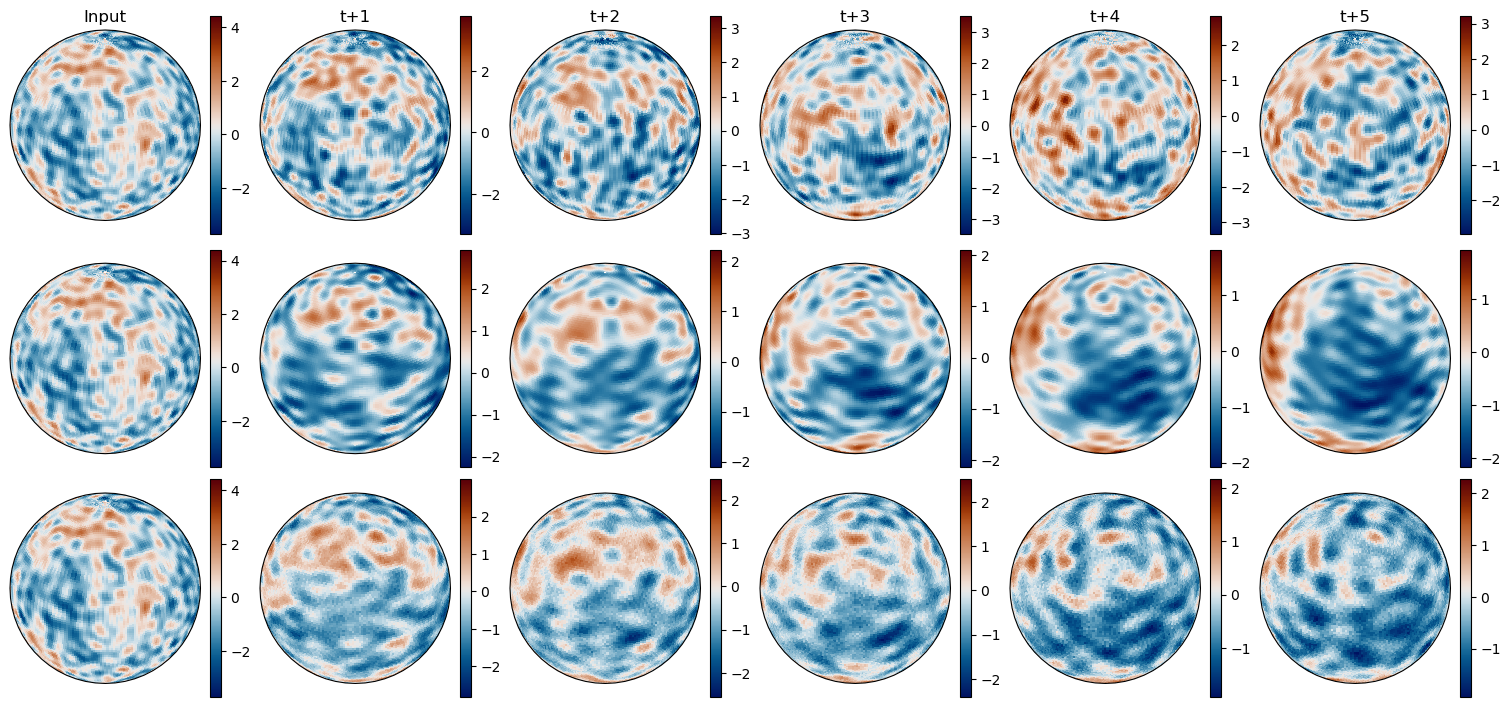

In [23]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,(eval_horizon+1), figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i in range(3):
    im = axs[i,0].pcolormesh(Lons, Lats, inp[0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)
    axs[0,0].set_title("Input")

for i in range(eval_horizon):
    im = axs[0,i+1].pcolormesh(Lons, Lats, truth[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[1,i+1].pcolormesh(Lons, Lats, pred_dropout[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[2,i+1].pcolormesh(Lons, Lats, pred_pfno[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    axs[0,i+1].set_title(f"t+{i+1}")


axs[0,0].set_ylabel("Truth")
axs[1,0].set_ylabel("Dropout")
axs[2,0].set_ylabel("PFNO")